In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# Validation cohort
 
Our look in the ewing's sarcoma cohort for signals around EWSR1 and FLI1 were not particularly interesting. With that said, it's worth running them through the validation cohort because it's easy.

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [3]:
# EWSR1-203 and FLI1-205 are the full length transcripts (they have tons of splice variants)
gene_gtfs = {}
gene_attrs = {"EWSR1": "EWSR1-203", "FLI1": "FLI1-205"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf

In [4]:
gene_gtfs["EWSR1"]["feature"].value_counts()

exon           17
CDS            17
UTR             2
transcript      1
start_codon     1
stop_codon      1
Name: feature, dtype: int64

In [5]:
genes = {
    "EWSR1": ["chr22", 29267009, 29301522],
    "FLI1": ["chr11", 128693072, 128814267],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

# Start looking at SVs around these genes

We're essentially just going to repeat this process, just to visualize. We load both the SVs and the dosage matrix. Note that we'll use the "validation" cohort, because that increasingly looks like we'll use that for discovery.

In [6]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.1.trio_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.1.trio_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,10,32,33,35,37,39,43,44,45,46,70,71,85,86,104,105,119,120,134,135,153,154,168,169,183,184,202,203,217,218,232,233,251,252,266,267,281,282,300,301,364,365,379,380,398,399,413,414,428,429,447,448,462,463,477,478,496,497,511,512,526,527,545,546,560,561,575,576,594,595,637,638,639,640,641,642,682,683,684,685,686,687,705,706,720,721,735,736,750,751,765,766,780,781,795,796,810,811,825,826,840,841,855,856,870,871,885,886,900,901,915,916,923,929,935) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
svs.head()

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,GENOTYPE_CONCORDANCE,GROUPWISE_MASKED_GENOTYPES,HET_PPV,HET_SENSITIVITY,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,...,SAS_FEMALE_N_HET,SAS_FEMALE_N_HOMALT,SAS_FEMALE_FREQ_HOMREF,SAS_FEMALE_FREQ_HET,SAS_FEMALE_FREQ_HOMALT,SAS_FEMALE_CN_NUMBER,SAS_FEMALE_CN_COUNT,SAS_FEMALE_CN_FREQ,SAS_FEMALE_CN_NONREF_COUNT,SAS_FEMALE_CN_NONREF_FREQ,SAS_MALE_AN,SAS_MALE_AC,SAS_MALE_AF,SAS_MALE_N_BI_GENOS,SAS_MALE_N_HOMREF,SAS_MALE_N_HET,SAS_MALE_N_HOMALT,SAS_MALE_FREQ_HOMREF,SAS_MALE_FREQ_HET,SAS_MALE_FREQ_HOMALT,SAS_MALE_CN_NUMBER,SAS_MALE_CN_COUNT,SAS_MALE_CN_FREQ,SAS_MALE_CN_NONREF_COUNT,SAS_MALE_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v2.1_sv_POPMAX_AF,gnomad_v2.1_sv_POPMAX_FREQ_HOMREF,gnomad_v2.1_sv_POPMAX_FREQ_HET,gnomad_v2.1_sv_POPMAX_FREQ_HOMALT,gnomad_v2.1_sv_POPMAX_CN_FREQ,gnomad_v2.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
0,chr1,12000,30001,PedSV.v2.0_CNV_chr1_1,CNV,0,None,depth,0,False,NaN,NaN,NaN,NaN,30001,NaN,RD,NaN,False,NaN,NaN,False,NaN,NaN,NaN,0,0.000000,NaN,All_20_Batches.chr1.final_cleanup_CNV_chr1_1,NaN,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,OR4F5,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","neuroblastoma_chromHMM15_EnhG_conserved,neurob...",NaN,NaN,NaN,NaN,334.0,334.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,"0,1,10,1,1","0.0,0.07692310214042664,0.7692310214042664,0.0...",3.0,0.230769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,"0,0,20,8,1","0.0,0.0,0.6896550059318542,0.2758620083332062,...",9.0,0.310345,NaN,NaN,NaN,NaN,"0.0,0.02982950024306774,0.6353979706764221,0.3...",NaN,NaN,NaN,NaN,NaN,"0.0,0.03440900146961212,0.6473119854927063,0.2...",NaN,NaN,NaN,NaN,NaN,"0.0,0.020920999348163605,0.6487470269203186,0....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIALLELIC
1,chr1,12000,40001,PedSV.v2.0_DUP_chr1_1,DUP,386,0.029366999864578247,depth,13144,False,NaN,NaN,NaN,NaN,40001,NaN,RD,NaN,False,NaN,NaN,False,NaN,NaN,NaN,0,0.048288,NaN,All_20_Batches.chr1.final_cleanup_DUP_chr1_1,0.0,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,OR4F5,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","neuroblastoma_chromHMM15_EnhG_conserved,neurob...",NaN,NaN,NaN,NaN,85.0,62.889599,NaN,...,NaN,NaN,1.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,56.0,1.0,0.017857,NaN,NaN,NaN,NaN,0.964286,0.035714,0.000000,NaN,NaN,NaN,NaN,NaN,0.192387,0.973171,0.162551,0.111111,NaN,NaN,0.182278,0.986517,0.156962,0.103797,NaN,NaN,0.047414,0.975527,0.064000,0.021552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
2,chr1,48000,129001,PedSV.v2.0_DUP_chr1_4,DUP,1601,0.12180499732494354,depth,13144,False,NaN,NaN,NaN,NaN,129001,NaN,RD,0.410,False,0.000000,NaN,False,NaN,NaN,NaN,0,0.048288,0.000000,All_20_Batches.chr1.final_cleanup_DUP_chr1_3,0.0,False,NaN,OR4F5,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","osteosarcoma_chromHMM15_Quies,osteosarcoma_chr...",NaN,NaN,NaN,NaN,19.0,6.077650,NaN,...,NaN,NaN,0.833333,0.166667,0.0,NaN,NaN,NaN,NaN,NaN,56.0,15.0,0.267857,NaN,NaN,NaN,NaN,0.500000,0.464286,0.035714,NaN,NaN,NaN,NaN,NaN,0.529255,0.840571,0.632979,0.212766,NaN,NaN,0.334177,0.836040,0.

We now get our sample level data. For this analysis, we focus on Ewing's and the Ewing's controls.

In [10]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.1.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

trio_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.1.trio_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
ewings_samples = metadata[(metadata["disease"] == "ewing") & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
ewings_samples = sorted(set(trio_samples) & set(ewings_samples))

control_samples = metadata[(metadata["ewing_control"]) & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
control_samples = sorted(set(trio_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(ewings_samples), len(control_samples)

(249, 2659)

And we subset the dosages to just these samples:

In [11]:
dosages = dosages[['#chr', 'start', 'end', 'ID'] + ewings_samples + control_samples]

We also remove all SVs that have no counts in genotyped samples. We don't care about these.

In [12]:
# identify the counts of each SV
sv_counts = dosages.iloc[:, 4:].fillna(0).sum(axis = 1)

# subset down SVs and dosages
svs = svs[sv_counts != 0]
dosages = dosages[sv_counts != 0]

In [13]:
svs.shape, dosages.shape

((173023, 944), (173023, 2912))

We begin by identifying structural variants that fall within our regions of interest. We only include SVs that pass quality filters (for now). We expand our search space to 1 Mb outside of these genes.

There are some small peculiarities that we should consider. Namely:
* SVs that span a region are included if any part of there region is 1 Mb away
* Complex SVs are included if any component SV is in the region


In [14]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [15]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr11,124239804,134089457,PedSV.v2.0_INV_chr11_23,FLI1
1,chr11,128214384,128216760,PedSV.v2.0_DEL_chr11_9523,FLI1


In [16]:
svs_in_regions.shape

(110, 5)

So it looks like there's a handful of SVs in this region. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [17]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [18]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr22,29729402,29729577,PedSV.v2.0_CPX_chr5_72,EWSR1
1,chr11,129143073,129143620,PedSV.v2.0_CPX_chr11_276,FLI1


In [19]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(2, 1)

So looks like 1 SV was missed in our initial simple overlap. It's pretty obvious why this is the case:

In [20]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,GENOTYPE_CONCORDANCE,GROUPWISE_MASKED_GENOTYPES,HET_PPV,HET_SENSITIVITY,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,...,SAS_FEMALE_N_HET,SAS_FEMALE_N_HOMALT,SAS_FEMALE_FREQ_HOMREF,SAS_FEMALE_FREQ_HET,SAS_FEMALE_FREQ_HOMALT,SAS_FEMALE_CN_NUMBER,SAS_FEMALE_CN_COUNT,SAS_FEMALE_CN_FREQ,SAS_FEMALE_CN_NONREF_COUNT,SAS_FEMALE_CN_NONREF_FREQ,SAS_MALE_AN,SAS_MALE_AC,SAS_MALE_AF,SAS_MALE_N_BI_GENOS,SAS_MALE_N_HOMREF,SAS_MALE_N_HET,SAS_MALE_N_HOMALT,SAS_MALE_FREQ_HOMREF,SAS_MALE_FREQ_HET,SAS_MALE_FREQ_HOMALT,SAS_MALE_CN_NUMBER,SAS_MALE_CN_COUNT,SAS_MALE_CN_FREQ,SAS_MALE_CN_NONREF_COUNT,SAS_MALE_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v2.1_sv_POPMAX_AF,gnomad_v2.1_sv_POPMAX_FREQ_HOMREF,gnomad_v2.1_sv_POPMAX_FREQ_HET,gnomad_v2.1_sv_POPMAX_FREQ_HOMALT,gnomad_v2.1_sv_POPMAX_CN_FREQ,gnomad_v2.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
54860,chr5,31244570,31244571,PedSV.v2.0_CPX_chr5_72,CPX,13,0.0009399860282428563,manta,13830,True,chr22,NaN,DUP_chr22:29729402-29729577,dDUP,31244571,29729402.0,"PE,SR",NaN,False,NaN,NaN,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr5.final_cleanup_CPX_chr5_121,0.0,False,NaN,NaN,NaN,False,CABP7,CDH6,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...",NaN,NaN,NaN,NaN,NaN,119.0,103.000000,DUP_chr22:29729402-29729577,...,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,58.0,0.0,0.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.011538,1.00,0.015385,0.003846,NaN,NaN,0.010613,1.000000,0.016509,0.002358,NaN,NaN,0.002092,1.000000,0.004184,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
119717,chr11,129145382,129145383,PedSV.v2.0_CPX_chr11_276,CPX,1931,0.139624,"manta,wham",13830,True,chr11,NaN,DUP_chr11:129143073-129143620,dDUP,129145383,129143073.0,"PE,SR",NaN,False,NaN,NaN,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr11.final_cleanup_CPX_chr11_452,0.0,False,NaN,NaN,NaN,False,NaN,ARHGAP32,NaN,NaN,NaN,NaN,"ewing_ABC_MAX_enhancer_unconserved,ewing_and_o...",NaN,NaN,NaN,NaN,NaN,122.0,88.884499,DUP_chr11:129143073-129143620,...,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,58.0,12.0,0.206897,NaN,NaN,NaN,NaN,0.655172,0.275862,0.068966,NaN,NaN,NaN,NaN,NaN,0.149322,0.85,0.229754,0.036649,NaN,NaN,0.153974,0.839623,0.242884,0.032532,NaN,NaN,0.144751,0.824268,0.216854,0.046875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


We can see why this was missed - it's a dispersed duplication where a region of chromosome 5 (?) was inserted into a region of chromosome 22.

In any case, we can now generate a (preliminary) list of SVs that are within 1 Mb of EWSR1 or FLI1.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [21]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

# drop duplicates (only happens if an SV is simple but part of a complex SV)
svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = ['name'])

In [22]:
len(svs_in_regions_names)

111

So a decent number of SVs in this dataset fall within this region. Briefly, Ryan and Riaz wanted to know if there are any MCNVs


In [23]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             53
DUP             21
INS:ME:ALU      20
INS:ME:LINE1     5
INS:ME:SVA       5
INS              4
CPX              2
INV              1
Name: svtype, dtype: int64

So no. We fetch all these SVs from the original dataset now and apply some filters:

In [24]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. Only works because no CNVs (which have AF = "None")
subset_svs['AF'] = subset_svs['AF'].astype(float)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS    111
Name: FILTER, dtype: int64

Rare:
 True     94
False    17
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [25]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(111, 946)

In [26]:
svs_to_keep["svtype"].value_counts()

DEL             53
DUP             21
INS:ME:ALU      20
INS:ME:LINE1     5
INS:ME:SVA       5
INS              4
CPX              2
INV              1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

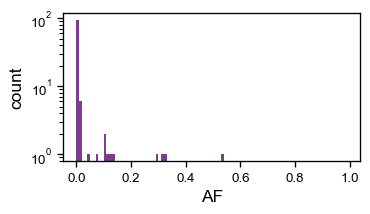

In [27]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [28]:
(svs_to_keep["AF"] < 0.01).value_counts()

True     94
False    17
Name: AF, dtype: int64

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [29]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_04DNDVQ4,PT_04JFGZG0,PT_0B57G8G3,PT_0BNTBQ7Q,PT_0CPPWCBM,PT_0FZKC12F,PT_0GVTWP1T,PT_0GWCW52B,PT_0N3XTPFC,PT_0PCC8H90,PT_0SRVYEJJ,PT_0X089RCD,PT_154SQQR4,PT_1JYPH1DC,PT_1N4DT7CC,PT_1NDK2HPT,PT_1QGFS9Q2,PT_1V935759,PT_22WPGEAV,PT_248C2SF4,PT_2HNFY58J,PT_2T6RG6D6,PT_30GP38FB,PT_3404N0X0,PT_38T8JVTM,PT_394BKFE0,PT_3C3Z4FY5,PT_3KH4CZCQ,PT_3M9D1ZJF,PT_3P1VK918,PT_3R4AK487,PT_3VW2Y6M5,PT_3Z7VRM0H,PT_469265KR,PT_48CBMA1S,PT_4AV8E5HP,PT_4B82676F,PT_4FSWQGNW,PT_4H6HM0KG,PT_4PYE849B,PT_4WBVPNBF,PT_4Z8ZPYM6,...,TPMCCDG9665,TPMCCDG9683,TPMCCDG9686,TPMCCDG9689,TPMCCDG9710,TPMCCDG9711,TPMCCDG9727,TPMCCDG9731,TPMCCDG9743,TPMCCDG9751,TPMCCDG9756,TPMCCDG9765,TPMCCDG9771,TPMCCDG9772,TPMCCDG9776,TPMCCDG9777,TPMCCDG9778,TPMCCDG9789,TPMCCDG9791,TPMCCDG9796,TPMCCDG9811,TPMCCDG9813,TPMCCDG9815,TPMCCDG9816,TPMCCDG9818,TPMCCDG9821,TPMCCDG9838,TPMCCDG9840,TPMCCDG9841,TPMCCDG9848,TPMCCDG9849,TPMCCDG9864,TPMCCDG9865,TPMCCDG9886,TPMCCDG9893,TPMCCDG9902,TPMCCDG9912,TPMCCDG9919,TPMCCDG9928,TPMCCDG9941,TPMCCDG9945,TPMCCDG9946,TPMCCDG9969,TPMCCDG9973,TPMCCDG9976,TPMCCDG9982,TPMCCDG9992,TPMCCDG9993,TPMCCDG9995,TPMCCDG9999
1,PedSV.v2.0_DEL_chr11_9523,FLI1,0.004483,True,chr11,128214385,128216760,PedSV.v2.0_DEL_chr11_9523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.v2.0_DEL_chr11_9524,FLI1,0.002098,True,chr11,128214735,128214799,PedSV.v2.0_DEL_chr11_9524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [30]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [ewings_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [31]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,PedSV.v2.0_DEL_chr11_9523,FLI1,chr11,128214385,128216760,0.004483,True,249,0,0,2642,16,1,128215572.5
1,PedSV.v2.0_DEL_chr11_9524,FLI1,chr11,128214735,128214799,0.002098,True,249,0,0,2655,4,0,128214767.0


Next we add some columns for allele frequency.

In [32]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [33]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,PedSV.v2.0_DEL_chr11_9523,FLI1,chr11,128214385,128216760,0.004483,True,249,0,0,2642,16,1,128215572.5,0.0,0.003385
1,PedSV.v2.0_DEL_chr11_9524,FLI1,chr11,128214735,128214799,0.002098,True,249,0,0,2655,4,0,128214767.0,0.0,0.000752


In [34]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
EWSR1,1.000000,0.032129,0.999624,0.046258
FLI1,0.919679,0.072289,0.920271,0.060549


Interesting--unless I've made a mistake, the controls have more rare SVs around these genes than controls.

Any smoking guns in terms of SVs?

In [35]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(10)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
5,PedSV.v2.0_INS_chr11_3758,FLI1,chr11,128274149,128274149,0.006732,True,237,8,0,2571,35,0,128274149.0,0.016327,0.006715
43,PedSV.v2.0_DEL_chr11_9574,FLI1,chr11,129011533,129011598,0.000289,True,248,0,1,2657,2,0,129011565.5,0.004016,0.000376
53,PedSV.v2.0_INS_chr11_3778,FLI1,chr11,129127733,129127733,0.000579,True,246,2,0,2656,3,0,129127733.0,0.004032,0.000564
88,PedSV.v2.0_DEL_chr22_1539,EWSR1,chr22,29446760,29446900,0.000221,True,238,1,0,2650,0,0,29446830.0,0.002092,0.000000
94,PedSV.v2.0_DUP_chr22_599,EWSR1,chr22,29573598,29574608,0.000072,True,248,1,0,2659,0,0,29574103.0,0.002008,0.000000
44,PedSV.v2.0_DEL_chr11_9575,FLI1,chr11,129035101,129037537,0.000072,True,248,1,0,2659,0,0,129036319.0,0.002008,0.000000
83,PedSV.v2.0_DEL_chr22_1530,EWSR1,chr22,29371630,29373144,0.000217,True,248,1,0,2659,0,0,29372387.0,0.002008,0.000000
70,PedSV.v2.0_DUP_chr22_579,EWSR1,chr22,28901648,28901701,0.003762,True,247,2,0,2649,9,1,28901674.5,0.004016,0.002068
58,PedSV.v2.0_DEL_chr11_9586,FLI1,chr11,129181429,129183358,0.000145,True,248,1,0,2658,1,0,129182393.5,0.002008,0.000188
31,PedSV.v2.0_DEL_chr11_9554,FLI1,chr11,128824789,128824859,0.000145,True,248,1,0,2658,1,0,128824824.0,0.002008,0.000188


In [36]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
47,PedSV.v2.0_INS_chr11_3774,FLI1,chr11,129046369,129046369,0.016229,False,243,5,0,2557,98,0,129046369.0,0.010081,0.018456
63,PedSV.v2.0_INS_chr22_329,EWSR1,chr22,28781346,28781346,0.534490,False,0,235,14,4,2453,202,28781346.0,0.528112,0.537232
3,PedSV.v2.0_DUP_chr11_2933,FLI1,chr11,128226922,128226985,0.312003,False,110,121,18,1180,1207,272,128226953.5,0.315261,0.329259
85,PedSV.v2.0_DUP_chr22_591,EWSR1,chr22,29410573,29410660,0.129863,False,189,60,0,1874,784,1,29410616.5,0.120482,0.147800


I find that somewhat surprising... there are several instances where the number of SVs in a gene is different between cases and controls, but it seems to favor the controls. What could be the reason for this, ancestry? Artifact?

## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


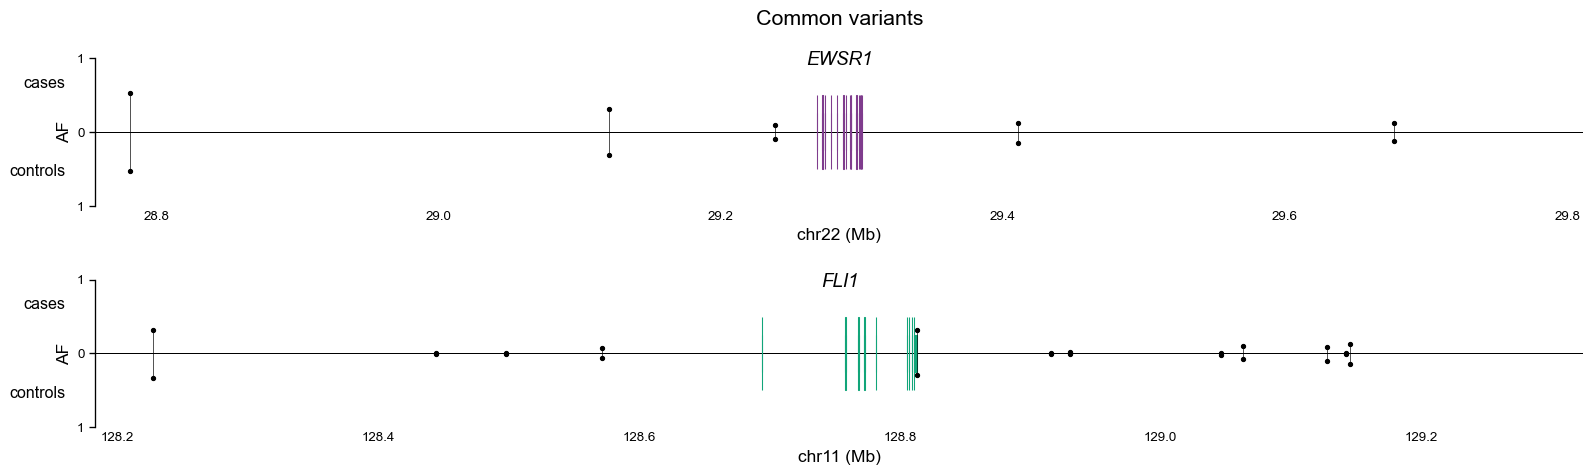

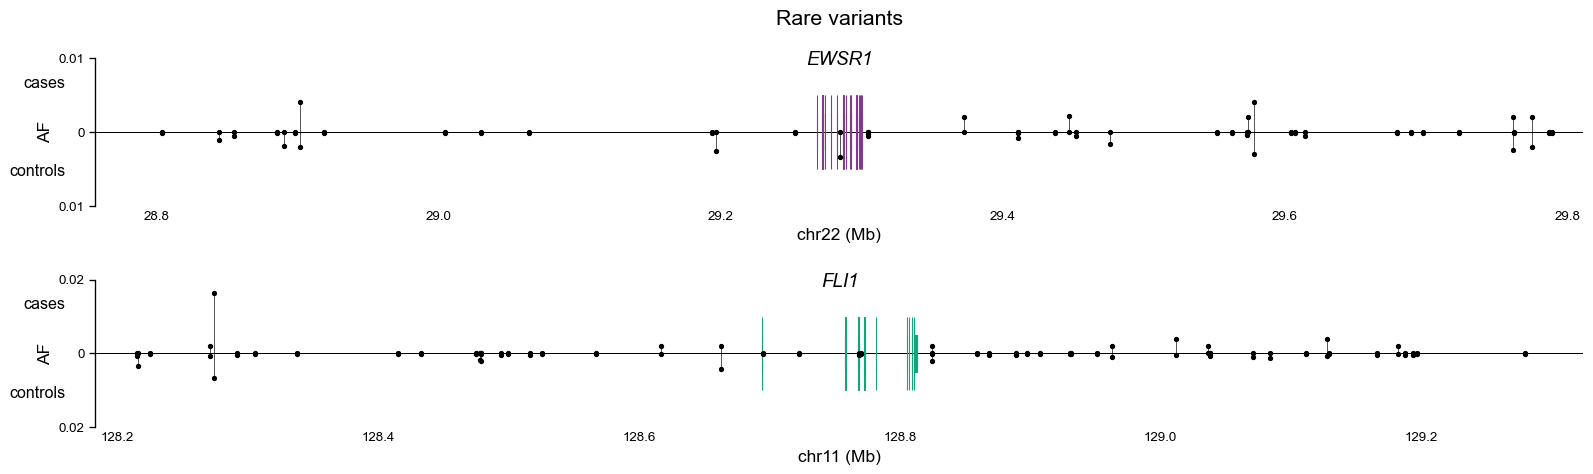

In [37]:
for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.9)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/{plot}.png")

# Begin some association analyses

* We'll begin following up on some of these analyses. We'll begin by exploring two:

1. The rare SV burden between cases and controls.
2. Association testing with individual SVs.

These are pretty simple models, based strictly on logistic regression models, so I'm fine to just do this in Python. We'll reference the R scripts for which variables to include in the model

## Rare and Common SV burden between cases and controls

This is prety straightforward. Essentially, our model is as follows:

`logit(case_status) ~ count_of_rare/common_SVs + ancestry_PCs + sex`

After some discussion with Ryan, we're leaving off coverage.

Shouldn't be too hard to construct. We'll start with common first.

In [39]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we determine the dosages

In [40]:
# for both ewsr1 and fli1, and for rare, common, and combined variants, we count
for gene in gene_locs["gene"]:
    for rare in [True, False, 'combined']:
        
        if rare in [True, False]:
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["rare"] == rare)
                & (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare ' + gene if rare else 'common ' + gene
        elif rare == "combined":
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare + common ' + gene

        sv_counts = (gene_svs[ewings_samples + control_samples] > 0).sum(axis=0)
        
        model_data.loc[sv_counts.index, label] = sv_counts

for label in ['rare', 'common', 'rare + common']:
    model_data[label + " combined"] = model_data[label + " EWSR1"] + model_data[label + " FLI1"]
    model_data[label + "_combined_one_hot"] = (
        (model_data[label + " EWSR1"] > 0) + (model_data[label + " FLI1"] > 0)
    ).astype(int)


Now we run the model

In [41]:
for gene in gene_locs["gene"].to_list() + ["combined"]:
    for svtype in ['rare', 'common', 'rare + common']:
        
        column = svtype + ' ' + gene

        # run the model
        endog = model_data["disease"]
        exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
        model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)

        coeff = model.params[1]
        p = model.pvalues[1]
        print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)

        # also try a one-hot encoding
        if gene != "combined":
            exog[column] = (model_data[column] > 0).astype(int)
        else:
            exog[column] = model_data[svtype + "_combined_one_hot"]

        try:
            one_hot_model = sm.Logit(
            endog,
            exog,
            ).fit(disp=0)
        except:
            print('Model failed')
            continue

        coeff = one_hot_model.params[1]
        p = one_hot_model.pvalues[1]
        print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare EWSR1 coeff: 0.26933176857552804 p: 0.418501459883461
SV one hot rare EWSR1 coeff: 0.36089495814656974 p: 0.3620540210120399
SV burden common EWSR1 coeff: -0.11515591534136106 p: 0.13110577726983905
SV one hot common EWSR1 coeff: 15.634803767503715 p: 0.9977971858322633
SV burden rare + common EWSR1 coeff: -0.09893497854174446 p: 0.1856556971810035
SV one hot rare + common EWSR1 coeff: 15.634803767503715 p: 0.9977971858322633
SV burden rare FLI1 coeff: 0.3916424136480355 p: 0.11943260330738055
SV one hot rare FLI1 coeff: 0.5141432489196656 p: 0.05738781214842999
SV burden common FLI1 coeff: 0.01814357456532239 p: 0.7895228062078454
SV one hot common FLI1 coeff: -0.15953561606584948 p: 0.5066272560862788
SV burden rare + common FLI1 coeff: 0.04068704649710675 p: 0.5381294935816336
SV one hot rare + common FLI1 coeff: -0.11282179066739065 p: 0.6522480408591801
SV burden rare combined coeff: 0.35134926798053845 p: 0.08300446079823774
SV one hot rare combined coeff: 0.463664

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


These results are interesting... the results are not significant with a window size of 1 Mb. In a previous version of this dataset, these results approached significance for a window size of 500 kb, but that is no longer true.

One thing we can quickly check is the number of SVs in this region per sample:

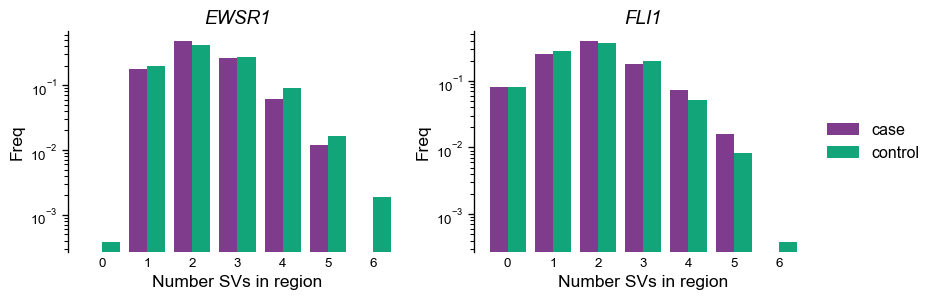

In [42]:
fig, axes = plt.subplots(1, len(gene_locs), figsize=(5 * len(gene_locs), 3))
for i, g in enumerate(gene_locs["gene"]):
    
    column = 'rare + common ' + g
    ax = axes[i]

    case_data = model_data.query("disease == 1")[column].value_counts()
    control_data = model_data.query("disease == 0")[column].value_counts()

    case_data = case_data / case_data.sum()
    control_data = control_data / control_data.sum()
    
    if 0 not in case_data.index:
        case_data.loc[0] = 0

    if 0 not in control_data.index:
        control_data.loc[0] = 0

    max_case = np.max(case_data.index)
    max_control = np.max(control_data.index)

    case_x = np.arange(0.3, max_case + 1.3, 1)
    control_x = np.arange(0.7, max_control + 1.7, 1)

    ax.bar(x=case_x, height=case_data.loc[range(max_case + 1)], width=0.4, label="case")
    ax.bar(x=control_x, height=control_data.loc[range(max_control + 1)], width=0.4, label="control")

    ax.set_yscale("log")
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    counts = np.arange(0, np.max([max_case, max_control]) + 1)
    ax.set_xticks(counts + 0.5)
    ax.set_xticklabels(counts)

    ax.set_xlabel("Number SVs in region")
    ax.set_ylabel("Freq")
    ax.set_title(g, fontstyle="italic")

axes[-1].legend(bbox_to_anchor=(1, 0.5))
fig.savefig('images/sv_burden.png')

So in fact in EWSR1 it looks like there's a small handful of controls that are different from cases.

## Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

In [43]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we add the genotypes to this model data.

In [44]:
sv_dosages = subsetted_gene_dosages.set_index("name")[ewings_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [45]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(ewings_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # run the model
    endog = sv_model_data_nonna["disease"]
    exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

    # suppress some failure warnings, which usually occur when we have few counts
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = sm.Logit(
            endog=endog,
            exog=exog,
        ).fit(disp=0, method="bfgs", maxiter=1000)

    # store
    sv_models[sv] = model
    sv_results.append(
        [
            sv,
            model.pvalues[1],
            model.params[1],
            num_cases_dropped,
            num_controls_dropped,
        ]
    )

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

Two SVs don't have any counts in the cases and only one count in the controls, which means that colinearity exists with the covariates:

In [46]:
sv_results[pd.isnull(sv_results['p'])]

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,


We drop these

In [47]:
sv_results = sv_results[~pd.isnull(sv_results['p'])]

Next we'll try plotting

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


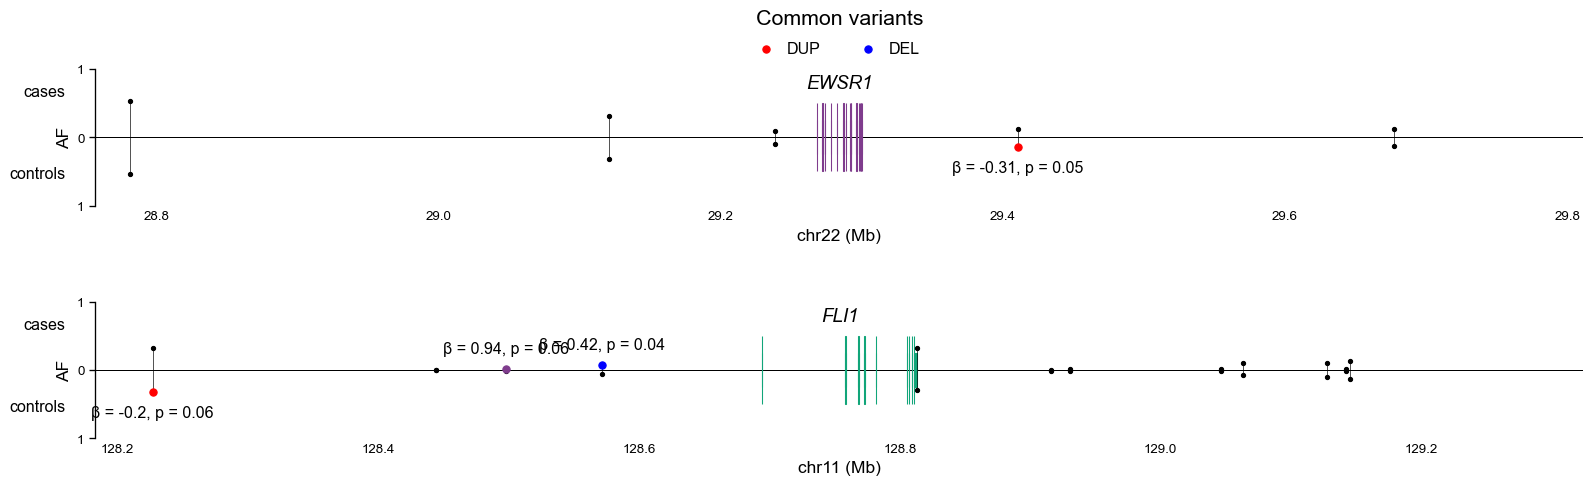

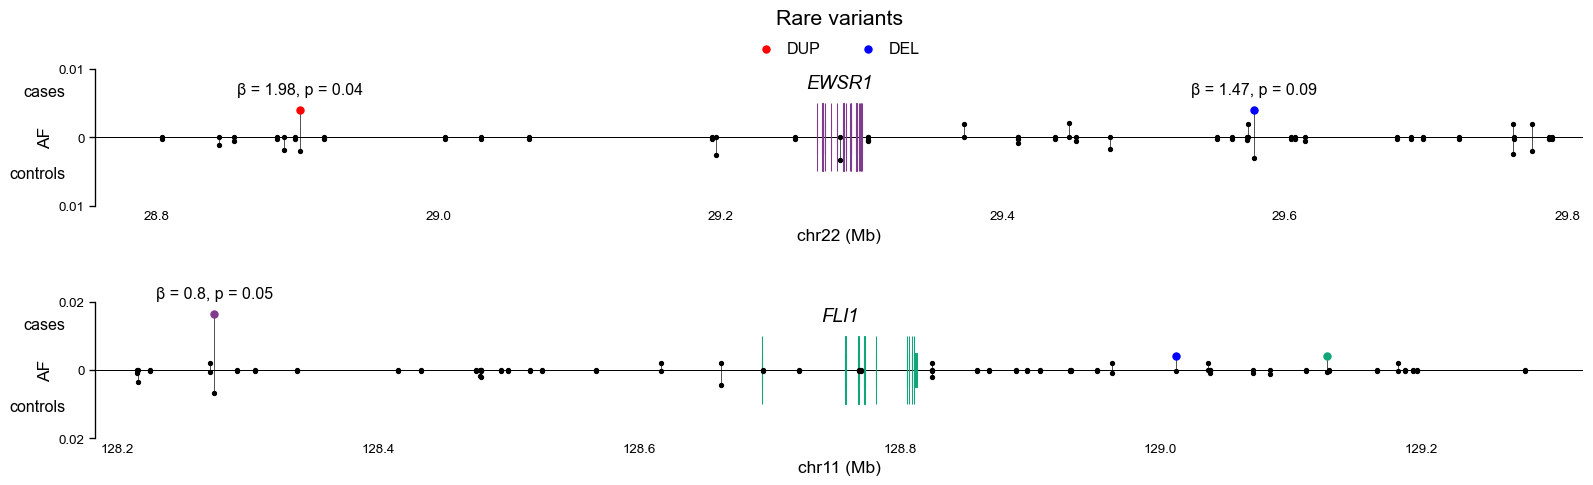

In [ ]:
sv_colors = {"DEL": "blue", "DUP": "red"}

for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.7},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    legend_handles = {}
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for j in range(len(gene_data)):
            loc = gene_data["midpoint"][j]
            name = gene_data["name"][j]

            case, control = case_y[j], control_y[j]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

            # look up the p value of the sv, if it exists
            if name in sv_results.index:
                p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

                if p_val < 0.1:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 if coeff > 0 else y - 0.3

                    sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=30, zorder=3, label=sv_type
                    )

                    if sv_type in ["DUP", "DEL"]:
                        legend_handles[sv_type] = scatter

                    # add text for coeff
                    if coeff < 3:
                        ax.text(
                            x=loc,
                            y=text_y,
                            s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                            ha="center",
                            va="center",
                        )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.3,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    axes[0].legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0.43, 1.15),
        ncol=2,
        handletextpad=0.3,
    )

    fig.savefig(f"images/{plot}.png")